Importamos las librerias esenciales. 

In [72]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

Leemos los datos desde el archivo CSV. La carga de datos es el primer paso crucial en cualquier análisis.

Para predecir el comportamiento de los consumidores, se usará la fuente de datos (dataset) 
Mall_Customers.csv, puede ser bajada de la ruta https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-Python  

El dataset consta de los siguientes campos: 
1. CustomerID: Identificación del cliente. 
2. Gender: Genero del cliente. 
3. Age: Edad del cliente. 
4. AnnualIncome: Ingresos anuales del cliente. 
5. SpendingScore: Puntuación del gasto, valor entre 1 y 100, que indica cuánto ha gastado un cliente 
en el centro comercial; cuanto más valor, más puntaje. 


In [73]:
datos = pl.read_csv("Mall_Customers.csv")

In [74]:
datos.head()

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
i64,str,i64,i64,i64
1,"""Male""",19,15,39
2,"""Male""",21,15,81
3,"""Female""",20,16,6
4,"""Female""",23,16,77
5,"""Female""",31,17,40


In [75]:
datos.tail()

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
i64,str,i64,i64,i64
196,"""Female""",35,120,79
197,"""Female""",45,126,28
198,"""Male""",32,126,74
199,"""Male""",32,137,18
200,"""Male""",30,137,83


In [76]:
datos.shape

(200, 5)

In [77]:
datos.glimpse()

Rows: 200
Columns: 5
$ CustomerID             <i64> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ Gender                 <str> 'Male', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female', 'Female', 'Male', 'Female'
$ Age                    <i64> 19, 21, 20, 23, 31, 22, 35, 23, 64, 30
$ Annual Income (k$)     <i64> 15, 15, 16, 16, 17, 17, 18, 18, 19, 19
$ Spending Score (1-100) <i64> 39, 81, 6, 77, 40, 76, 6, 94, 3, 72



In [78]:
datos.null_count()

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
u32,u32,u32,u32,u32
0,0,0,0,0


In [79]:
datos.describe()

statistic,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [80]:

datos_num = datos[["CustomerID","Age","Annual Income (k$)","Spending Score (1-100)"]]
datos_num 

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64,i64
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
…,…,…,…
196,35,120,79
197,45,126,28
198,32,126,74


In [81]:
datos_num.corr()

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
f64,f64,f64,f64
1.0,-0.026763,0.977548,0.013835
-0.026763,1.0,-0.012398,-0.327227
0.977548,-0.012398,1.0,0.009903
0.013835,-0.327227,0.009903,1.0


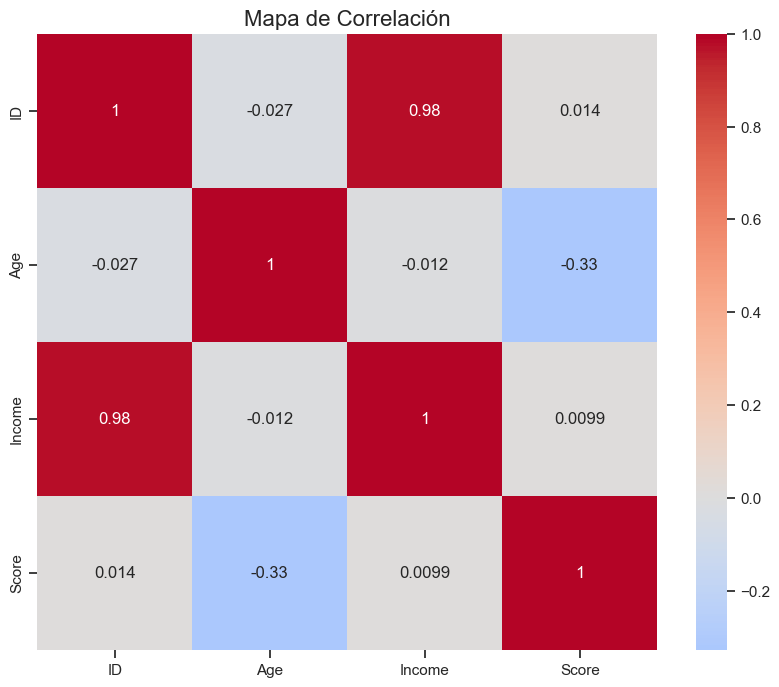

In [82]:
plt.figure(figsize=(10, 8))
sns.heatmap(datos_num.corr(), annot=True, cmap='coolwarm', center=0,
            xticklabels=['ID', 'Age', 'Income', 'Score'],
            yticklabels=['ID', 'Age', 'Income', 'Score'])
plt.title('Mapa de Correlación', fontsize=16)
plt.show()

Como existe relación espurea entre la varible CostumerID y Annual Income, procedemos a retirar la variable CostumerID para obtener una mejor correlacion entre variables

In [83]:
datos_num = datos[["Age","Annual Income (k$)","Spending Score (1-100)"]]
datos_num

Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64
19,15,39
21,15,81
20,16,6
23,16,77
31,17,40
…,…,…
35,120,79
45,126,28
32,126,74


In [84]:
datos_num.corr()

Age,Annual Income (k$),Spending Score (1-100)
f64,f64,f64
1.0,-0.012398,-0.327227
-0.012398,1.0,0.009903
-0.327227,0.009903,1.0


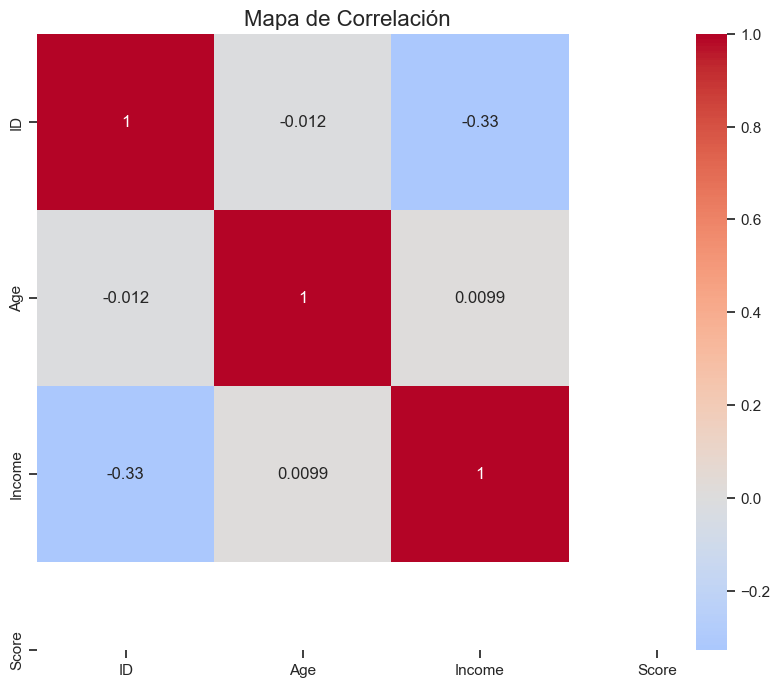

In [85]:
plt.figure(figsize=(10, 8))
sns.heatmap(datos_num.corr(), annot=True, cmap='coolwarm', center=0,
            xticklabels=['ID', 'Age', 'Income', 'Score'],
            yticklabels=['ID', 'Age', 'Income', 'Score'])
plt.title('Mapa de Correlación', fontsize=16)
plt.show()

Distribución anual del ingreso. La mayor parte del ingreso anual oscila entre 50.000 y 85.000 dólares.

Text(0, 0.5, 'Cantidad')

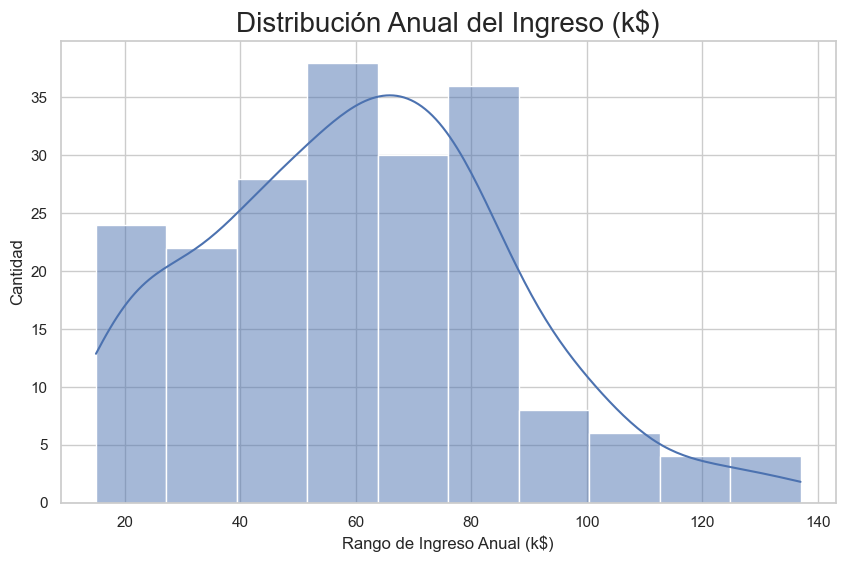

In [86]:
plt.figure(figsize=(10, 6))
sns.set_theme(style = 'whitegrid')
sns.histplot(datos['Annual Income (k$)'], kde=True)
plt.title('Distribución Anual del Ingreso (k$)', fontsize = 20)
plt.xlabel('Rango de Ingreso Anual (k$)')
plt.ylabel('Cantidad')

Distribución por edad. Hay clientes de una amplia variedad de edades.

Text(0, 0.5, 'Cantidad')

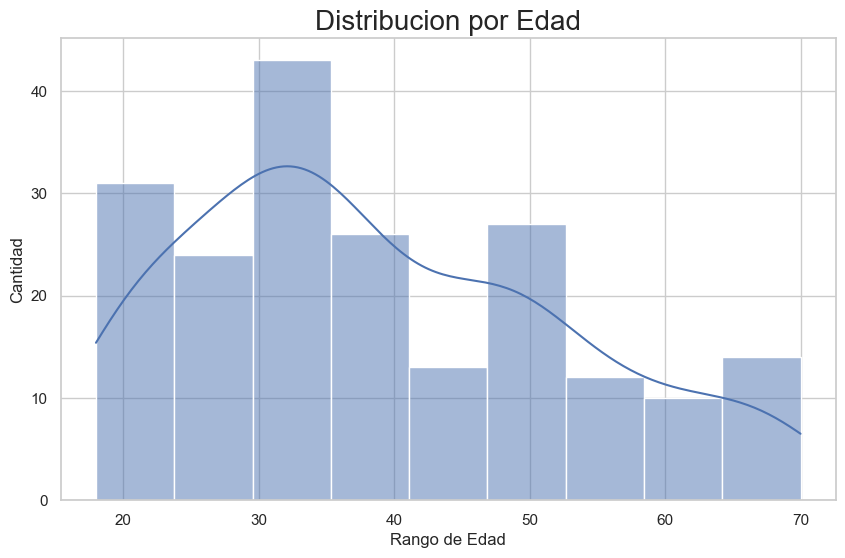

In [87]:
plt.figure(figsize=(10, 6))
sns.set_theme(style = 'whitegrid')
sns.histplot(datos['Age'], kde=True)
plt.title('Distribucion por Edad', fontsize = 20)
plt.xlabel('Rango de Edad')
plt.ylabel('Cantidad')

Distribucion del score asignado. La puntuación máxima de gasto está en el rango de 40 a 60.

Text(0, 0.5, 'Cantidad')

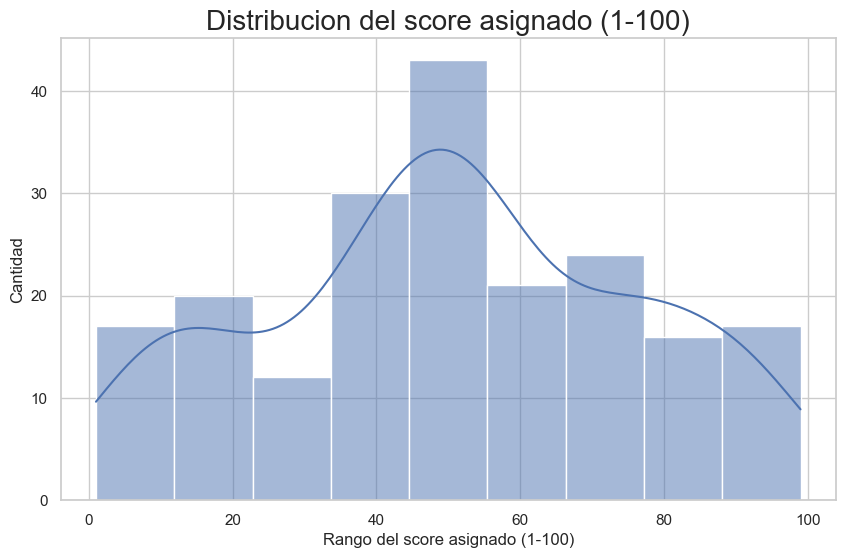

In [88]:
plt.figure(figsize=(10, 6))
sns.set_theme(style = 'whitegrid')
sns.histplot(datos['Spending Score (1-100)'], kde=True)
plt.title('Distribucion del score asignado (1-100)', fontsize = 20)
plt.xlabel('Rango del score asignado (1-100)')
plt.ylabel('Cantidad')

Analisis de Genero. Hay mas mujeres clientes que hombres.

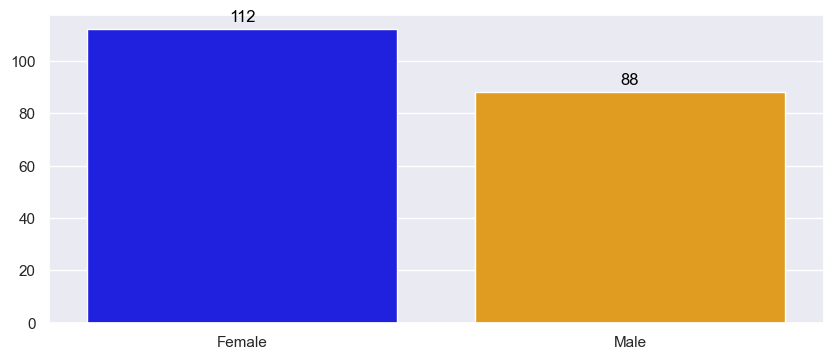

In [89]:
genders = datos['Gender'].value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
for i, count in enumerate(genders['count']):
    plt.text(i, count + 3, str(count), ha='center', color='black')
colors = ['blue', 'orange']
sns.barplot(x=genders.select(pl.col("Gender")).to_series().to_list(), y=genders.select(pl.col("count"), legend=False).to_series().to_list(), hue=genders.select(pl.col("Gender")).to_series().to_list(), palette=colors)
plt.show()

Relación entre las variables del Dataset

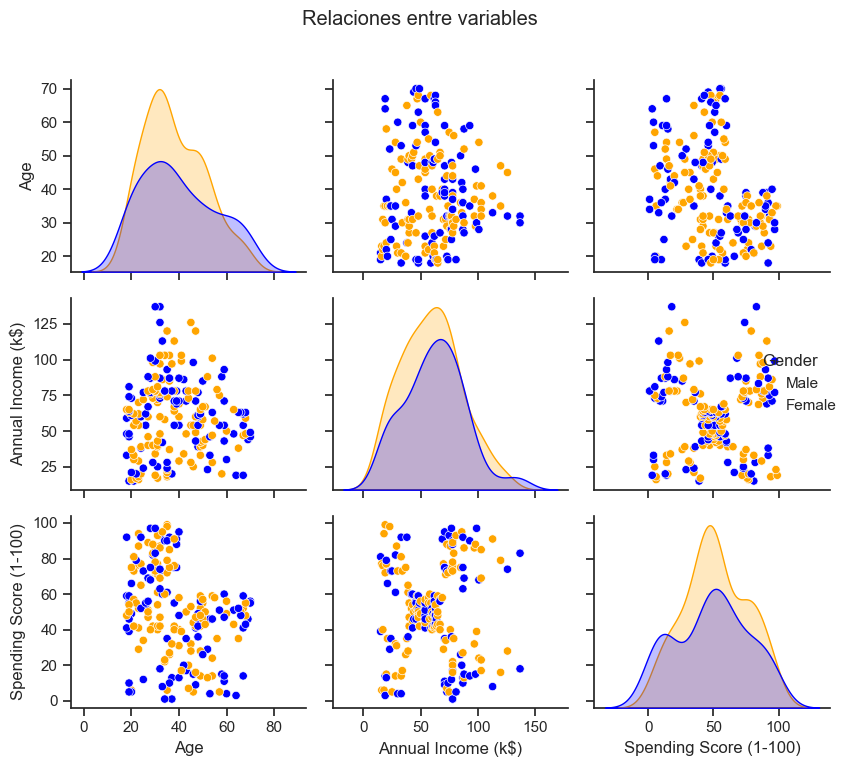

In [90]:
sns.set_theme(style="ticks")
pair_plot = sns.pairplot(datos.to_pandas(), 
                        vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
                        hue='Gender',
                        palette=['blue', 'orange'],
                        diag_kind='kde')

plt.suptitle('Relaciones entre variables', y=1.02)
plt.tight_layout()


## Analísis K-MEANS

### Agrupación en clústeres basada en 2 características.

En primer lugar, trabajamos solo con dos características: Annual income (K$)y Spending Score (1-100).Para ello, seleccionamos dichas columnas del dataset y las convertimos en un ndarray de NumPy, luego, asociamos este resultado a X, siendo esta la famosa matriz de características.

In [91]:
X = datos[["Annual Income (k$)", "Spending Score (1-100)"]].to_numpy()
X[: 5]

array([[15, 39],
       [15, 81],
       [16,  6],
       [16, 77],
       [17, 40]])

Al visualizar estas dos variables en un gráfico de dispersión, obtenemos una primera impresión de la distribución de los clientes. Los datos parecen contener algunos patrones.

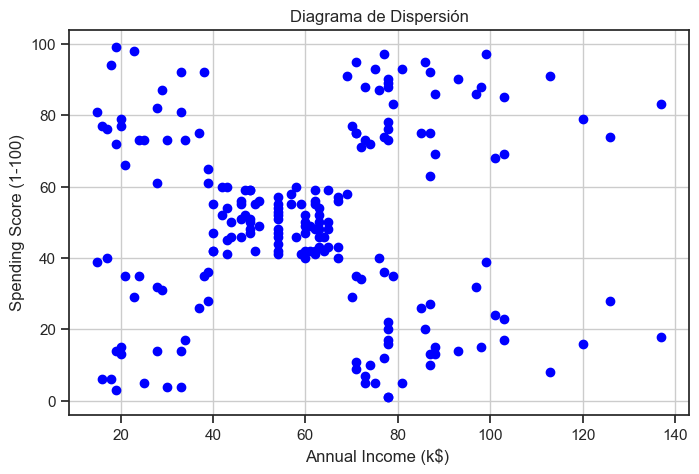

In [92]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], color='blue', marker='o')
plt.title('Diagrama de Dispersión')
plt.xlabel('Annual Income (k$) ')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

Ahora calculamos la suma de errores cuadrados (WSS) dentro del conglomerado para diferentes valores de k. A continuación, elegimos el k para el cual el WSS comienza a disminuir. Este valor de K nos proporciona el número óptimo de conglomerados para crear a partir de los datos sin procesar.

1. Ejecutar el algoritmo 10 veces: cuando K=1, K=2, … K=10
2. Calcularemos la suma de los cuadrados de cada clusters (WCSS)
3. Visualizaremos en un grafico cuando sucede ese cambio de tendencia mediante la gráfica del codo

In [93]:
wcss = []
n_clu = 10

for i in range(1, n_clu+1):

    kmeans = KMeans(n_clusters = i, 
                    init = "k-means++", 
                    max_iter = 300, 
                    n_init = 10, 
                    random_state = 42)

    kmeans.fit(X) 
    
    wcss.append(kmeans.inertia_)

In [94]:
wcss

[269981.28,
 181363.59595959593,
 106348.37306211122,
 73679.78903948836,
 44448.4554479337,
 37233.814510710006,
 30241.34361793658,
 25036.417604033988,
 21916.79478984373,
 20072.070939404002]

#### Método Elbow: Escogiendo numero óptimo K clústers

Conocido como el gráfico del codo. El eje x representa el número de clústeres. Este número se toma en el punto de articulación del codo. Este punto es donde la formación de clústeres es más relevante, ya que el valor de WCSS deja de disminuir repentinamente. En el gráfico, después de 5, la caída es mínima, por lo que 5 representa el número de clústeres.

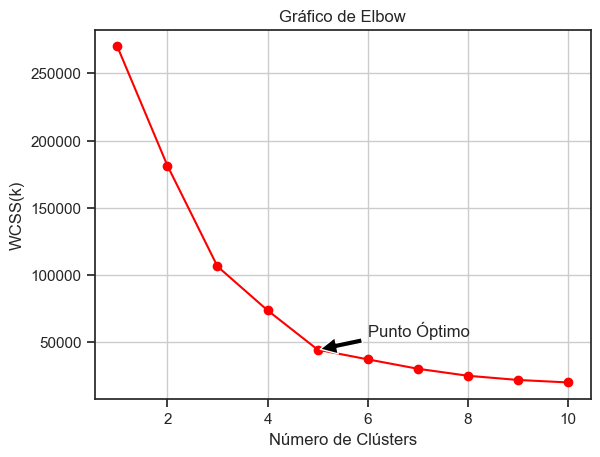

In [95]:
plt.plot(range(1,11), wcss, marker='o', color='red')
plt.title("Gráfico de Elbow")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS(k)")
plt.grid(True)

# Anotar el punto de codo para una mejor visualización
plt.annotate('Punto Óptimo', xy=(5, wcss[4]), 
             xytext=(6, wcss[4]+10000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)

#### El metodo de la Silueta (Silhouette)
El método de la silueta es otra técnica para determinar el número óptimo de clusters.
Este método calcula qué tan similar es un objeto a su propio cluster en comparación con otros clusters. El rango va de -1 a 1, donde:
- Un valor alto (cerca de 1) indica que el objeto está bien emparejado con su cluster
- Un valor cercano a 0 indica que el objeto está en la frontera entre dos clusters
- Un valor negativo indica que el objeto podría estar asignado al cluster equivocado

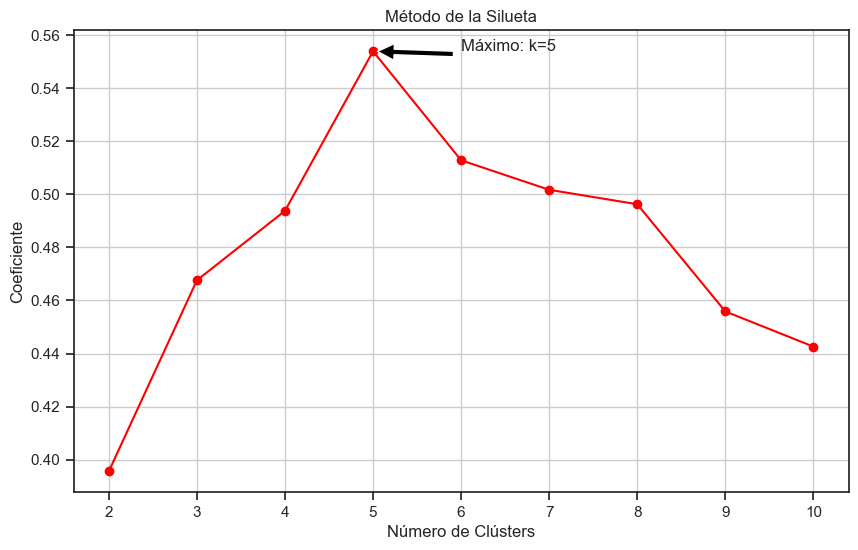

El coeficiente de silueta más alto se obtiene con k = 5
Valor del coeficiente: 0.5539


In [96]:
# Calculamos el coeficiente de la silueta para diferentes valores de k
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o', color='red')
plt.xlabel('Número de Clústers')
plt.ylabel('Coeficiente')
plt.title('Método de la Silueta')
plt.grid(True)

# Anotamos el valor máximo
k_optimo = K[silhouette_scores.index(max(silhouette_scores))]
plt.annotate(f'Máximo: k={k_optimo}', 
            xy=(k_optimo, max(silhouette_scores)),
            xytext=(k_optimo+1, max(silhouette_scores)),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

print(f"El coeficiente de silueta más alto se obtiene con k = {k_optimo}")
print(f"Valor del coeficiente: {max(silhouette_scores):.4f}")


Teniendo ya el K-óptimo, lo que vamos hacer es organizar nuestro dataset X en 5 grupos o clústeres distintos.

La idea, es volver a ejecutar el método K-means con K=5 para que el algoritmo encuentre las mejores 5 agrupaciones basándonos en las características de los datos.

In [97]:
kmeans = KMeans(n_clusters = 5, 
                init="k-means++", 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42)
           
y_kmeans = kmeans.fit_predict(X)


Mostramos las 10 primeras observaciones en los clústeres:

In [98]:
y_kmeans[0:10]

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2], dtype=int32)

Este DataFrame ampliado, X_clustered, nos permite examinar no solo las características originales de cada muestra, sino también su asignación a un clúster específico, abriendo un camino hacia un análisis detallado y contextualizado de los grupos identificados.

In [99]:
y_kmeans_series = pl.Series(name='Cluster Pred', values=y_kmeans)

X_clustered = datos.with_columns(y_kmeans_series)
X_clustered

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster Pred
i64,str,i64,i64,i64,i32
1,"""Male""",19,15,39,4
2,"""Male""",21,15,81,2
3,"""Female""",20,16,6,4
4,"""Female""",23,16,77,2
5,"""Female""",31,17,40,4
…,…,…,…,…,…
196,"""Female""",35,120,79,1
197,"""Female""",45,126,28,3
198,"""Male""",32,126,74,1


Visualización de clústeres y centroides.
Para ello, utilizamos un gráfico de dispersión para representar cada uno de los cinco clústeres identificados por el algoritmo K-Means. Cabe destacar que esto es posible gracias a que solo estamos analizados dos variables.

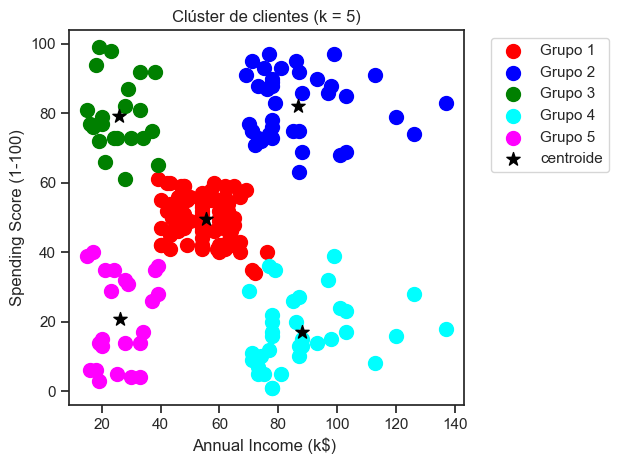

In [100]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], 
              s = 100, c = "red", label = "Grupo 1")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], 
              s = 100, c = "blue", label = "Grupo 2")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, 
              c = "green", label = "Grupo 3")
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, 
              c = "cyan", label = "Grupo 4")
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, 
              c = "magenta", label = "Grupo 5")

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
              s = 100, c = "black", label = "centroide", marker = '*')

plt.title('Clúster de clientes (k = 5)')
plt.xlabel('Annual Income (k$) ')
plt.ylabel('Spending Score (1-100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Los Puntos Centroides
Representan la posición promedio de los datos asignados a cada grupo y son clave para definir la estructura de la segmentación. Durante el proceso iterativo de K-means, los centroides se recalculan hasta que la agrupación se estabiliza. En resumen, los centroides actúan como referencia para asignar cada dato al clúster más adecuado.


In [101]:
kmeans.cluster_centers_

array([[55.2962963 , 49.51851852],
       [86.53846154, 82.12820513],
       [25.72727273, 79.36363636],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348]])

Por último, creamos un DataFrame con los CustomerID y sus correspondientes clusters

In [102]:
cluster_ids = X_clustered.select(['CustomerID']).with_columns(pl.Series(name='Cluster Pred', values=y_kmeans))
grouped_ids = cluster_ids.group_by('Cluster Pred').agg(pl.col('CustomerID'))

# Mostrar los clientes en cada cluster
for cluster in range(5):
    print(f"\nCluster {cluster} Customer IDs:")
    print(grouped_ids.filter(pl.col('Cluster Pred') == cluster).select('CustomerID').to_series().to_list())



Cluster 0 Customer IDs:
[[44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 127, 133, 143]]

Cluster 1 Customer IDs:
[[124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200]]

Cluster 2 Customer IDs:
[[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 46]]

Cluster 3 Customer IDs:
[[125, 129, 131, 135, 137, 139, 141, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199]]

Cluster 4 Customer IDs:
[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 3

### Agrupamiento de k-medias basado en datos 3D.

Ahora, trabajaremos con tres tipos de datos. Además del gasto y los ingresos anuales de los clientes, también consideraremos su edad.

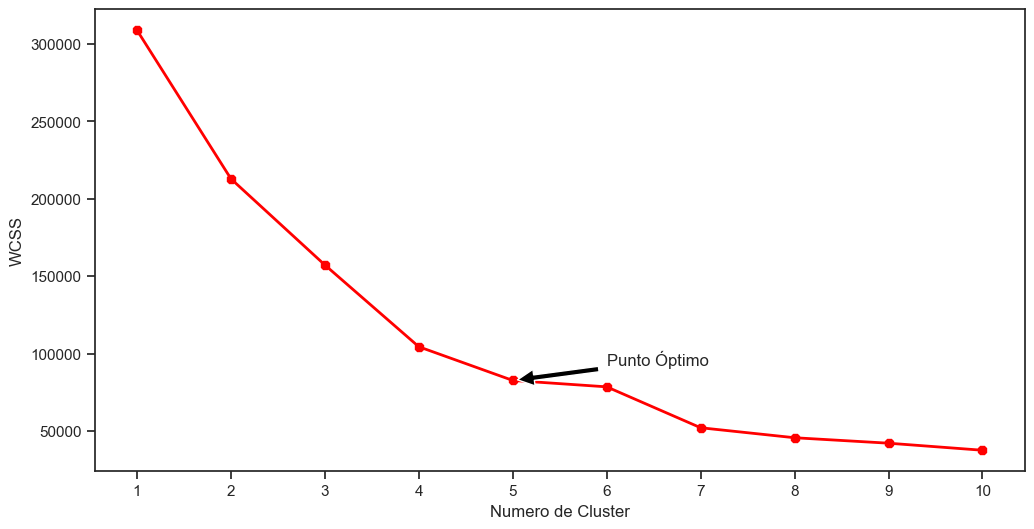

In [103]:
# Tomando las características
X1=datos[["Age","Annual Income (k$)","Spending Score (1-100)"]]
# Ahora calculamos la Suma de Errores Cuadrados dentro del Cluster (WSS) para diferentes valores de k)
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("Numero de Cluster")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")

# Anotar el punto de codo para una mejor visualización
plt.annotate('Punto Óptimo', xy=(5, wcss[4]), 
             xytext=(6, wcss[4]+10000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

La curva WCSS.
Aquí podemos asumir que K=5 será un buen valor.



In [115]:
# Elegimos el k para el cual WSS comienza a disminuir
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X1)
X1 = X1.with_columns(pl.Series(name="label", values=y))

In [116]:
X1

Age,Annual Income (k$),Spending Score (1-100),label
i64,i64,i64,i32
19,15,39,0
21,15,81,4
20,16,6,0
23,16,77,4
31,17,40,0
…,…,…,…
35,120,79,1
45,126,28,2
32,126,74,1


Visualización de clústeres y centroides.

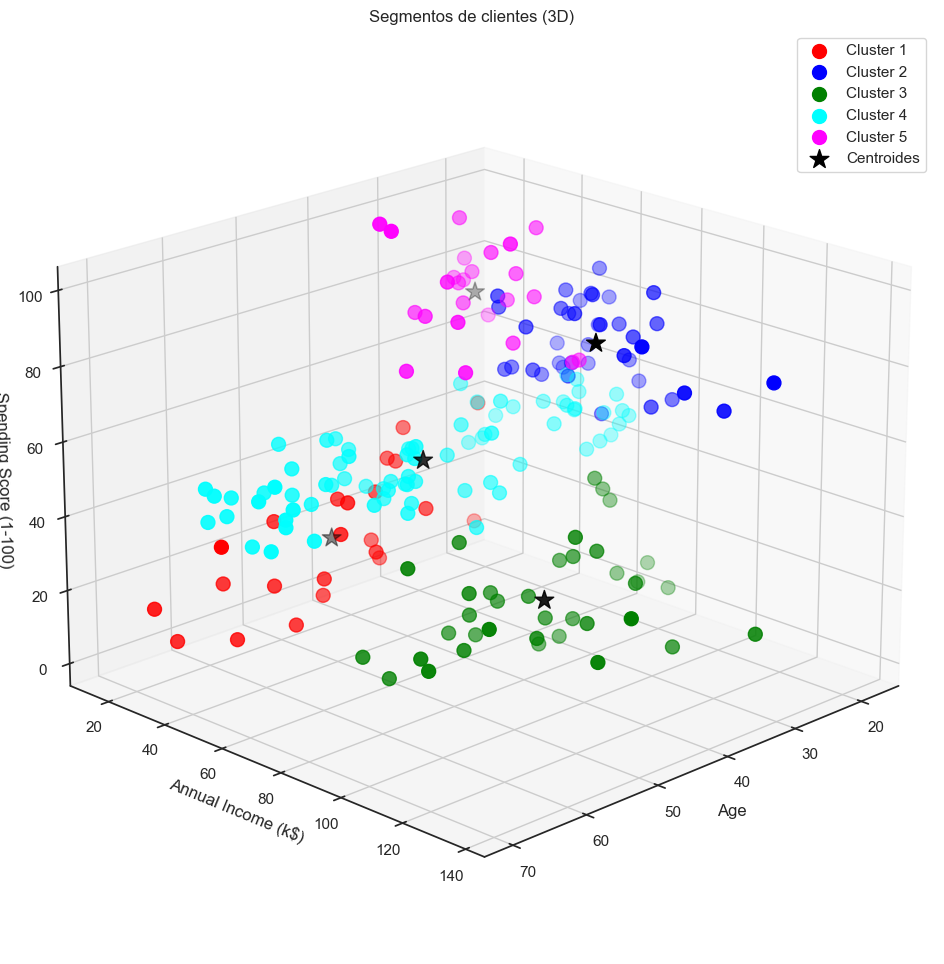

In [117]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.view_init(elev=20, azim=45)  # Ajustar el ángulo de visualización para una mejor visibilidad

# Graficar los puntos para cada clúster
colors = ['red', 'blue', 'green', 'cyan', 'magenta']
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

for i in range(5):
    cluster_points = X1.filter(pl.col('label') == i)
    ax.scatter(cluster_points['Age'],
              cluster_points['Annual Income (k$)'],
              cluster_points['Spending Score (1-100)'],
              c=colors[i],
              label=labels[i],
              s=100)

# Graficar los centroides
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], 
          centroids[:, 1], 
          centroids[:, 2], 
          c='black', 
          marker='*', 
          s=200, 
          label='Centroides')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Segmentos de clientes (3D)')
plt.legend()
plt.show()

Si queremos conocer los ID de los clientes, también podemos hacerlo.

In [107]:
# Agregar CustomerID a X1 y agrupar por etiqueta para mostrar los IDs en cada cluster
cluster_ids = datos.select(['CustomerID']).with_columns(pl.Series(name='Cluster', values=y))
grouped_ids = cluster_ids.group_by('Cluster').agg(pl.col('CustomerID'))

# Mostrar clientes en cada cluster
for cluster in range(5):
    print(f"\nCluster {cluster} Customer IDs:")
    print(grouped_ids.filter(pl.col('Cluster') == cluster).select('CustomerID').to_series().to_list())


Cluster 0 Customer IDs:
[[47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 127, 143]]

Cluster 1 Customer IDs:
[[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 66, 69]]

Cluster 2 Customer IDs:
[[124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200]]

Cluster 3 Customer IDs:
[[125, 129, 131, 133, 135, 137, 139, 141, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199]]

Cluster 4 Customer IDs:
[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 3

## Análisis con escalamiento de las variables

Pasamos al escalamiento de las variables

El escalonamiento de variables en K-means se realiza para garantizar que todas las variables tengan una influencia equitativa en la formación de los clusters. Esto es especialmente importante cuando las variables tienen diferentes escalas o unidades de medida.


In [108]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [109]:
X_scaled.shape
X_scaled[:5]

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992]])

calculamos la suma de errores cuadrados (WSS) dentro del conglomerado para diferentes valores de k. A continuación, elegimos el k para el cual el WSS comienza a disminuir. Este valor de K nos proporciona el número óptimo de conglomerados para crear a partir de los datos sin procesar.

1. Ejecutar el algoritmo 10 veces: cuando K=1, K=2, … K=10
2. Calcularemos la suma de los cuadrados de cada clusters (WCSS)
3. Visualizaremos en un grafico cuando sucede ese cambio de tendencia mediante la gráfica del codo

In [110]:
wcss = []
n_clu = 10

for i in range(1, n_clu+1):

    kmeans = KMeans(n_clusters = i, 
                    init = "k-means++", 
                    max_iter = 300, 
                    n_init = 10, 
                    random_state = 42)

    kmeans.fit(X_scaled) 
    
    wcss.append(kmeans.inertia_)

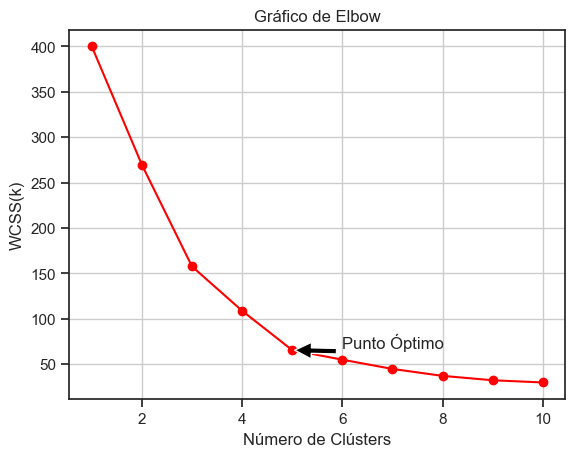

In [111]:
plt.plot(range(1,11), wcss, marker='o', color='red')
plt.title("Gráfico de Elbow")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS(k)")
plt.grid(True)

# Anotar el punto de codo para una mejor visualización
plt.annotate('Punto Óptimo', xy=(5, wcss[4]), 
             xytext=(6, wcss[4]+2),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)

In [119]:
kmeans = KMeans(n_clusters = 5, 
                init="k-means++", 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42)
           
y_kmeans = kmeans.fit_predict(X)

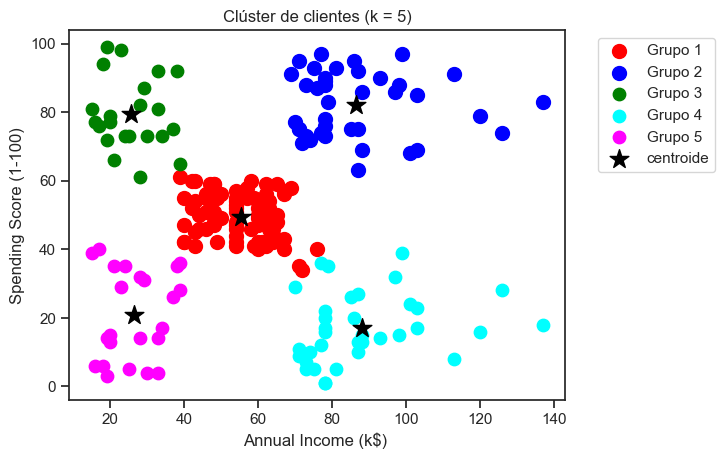

<Figure size 1000x800 with 0 Axes>

In [120]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], 
              s = 100, c = "red", label = "Grupo 1")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], 
              s = 100, c = "blue", label = "Grupo 2")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 80, 
              c = "green", label = "Grupo 3")
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 80, 
              c = "cyan", label = "Grupo 4")
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 80, 
              c = "magenta", label = "Grupo 5")

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
              s = 200, c = "black", label = "centroide", marker = '*')

plt.title('Clúster de clientes (k = 5)')
plt.xlabel('Annual Income (k$) ')
plt.ylabel('Spending Score (1-100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(10, 8))
plt.show()

## Conclusiones

El análisis de segmentación de clientes revela varias ideas clave:

1.  **Agrupación Óptima**

  *   Tanto los análisis 2D como 3D identificaron consistentemente 5 segmentos de clientes distintos.
  *   El método del codo validó esta elección, mostrando rendimientos decrecientes después de 5 clústeres.

2.  **Segmentos de Clientes Identificados:**

  *   Altos Ingresos, Alto Gasto (Grupo Objetivo)
  *   Altos Ingresos, Bajo Gasto (Grupo Potencial)
  *   Ingresos Promedio, Gasto Promedio (Grupo Estable)
  *   Bajos Ingresos, Alto Gasto (Grupo de Monitoreo Cuidadoso)
  *   Bajos Ingresos, Bajo Gasto (Grupo Básico)

3.  **Patrones Demográficos:**

  *   La distribución por género muestra más mujeres clientes que hombres.
  *   La distribución por edad es amplia, con una representación significativa en diferentes grupos de edad.
  *   Los ingresos anuales muestran una concentración entre 50.000 y 85.000 dólares.

4.  **Relaciones Clave entre Variables:**

  *   No hay una fuerte correlación entre la edad y los patrones de gasto.
  *   Los puntajes de ingresos y gastos muestran algunos patrones de agrupación, pero no una correlación directa.
  *   La edad y los ingresos muestran una correlación positiva moderada.

5.  **Implicaciones Comerciales:**

  *   Se pueden desarrollar estrategias de marketing dirigidas a cada segmento.
  *   La combinación de productos se puede optimizar en función de las características del segmento.
  *   Potencial para la participación personalizada del cliente basada en la pertenencia al segmento.

En síntesis, este trabajo muestra que se puede hacer segmentación de clientes en centros comerciales usando aprendizaje automático, lo que es rentable para la industria. Los gerentes deben entender las necesidades de los clientes y estudiar sus hábitos de compra. Sin embargo, implementar el aprendizaje automático de manera precisa es desafiante, ya que los comportamientos de los humanos pueden cambiar. Aun así, los resultados del estudio son prometedores para otras aplicaciones en la misma industria.